# Problem Description:
Every day, we browse and buy things on Amazon, watch Netflix, listen to music on Spotify, and so on. For example, when you want to view a new movie, you normally ask your friends for recommendations; they are aware of your tastes and appropriately recommend a suitable film.
Because everyone has their unique preferences, it's impossible to keep track of each user's preferences manually.

# Business Understanding:
Companies have customised Recommendation Engines that offer things to you based on powerful algorithms...
Recommendation Systems are similar in that they are nothing more than data filtering tools that employ algorithms to recommend the most relevant items to a certain user.

The Internet is a vast ocean of information, with millions of goods and a massive product catalogue. Some Users know exactly what they want, while others have no idea what to look for in such a big collection of information, and this is where Recommendation Systems come in handy.

Some things may be excellent but have not attained **Popularity** due to a lack of advertising; recommendation systems aid in the popularity of such items by bringing them to the attention of the public.

**Ad Targeting** is also aided by it. Let's say you're trying to buy a new laptop on the Internet; your recent searches have yielded laptop recommendations, and you'll soon encounter adverts on websites offering laptop savings. So, Ad Targeting is an advertising method that uses specialised software and algorithms to display adverts automatically based on the user's recent searches.

According to a research published by the Network Advertising Initiative in 2009, ad targeting generated 2.7 times as much money as non-targeted ads.
As a result, it also aids the product's organisation in **increasing revenues**.

# File Ingestion and Schema Validation

In [1]:
%%writefile testutility_electronics.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re

def read_yml_file(file_path):
    with open(file_path, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

def col_validate(df, col_config):
  cols = df.columns
  cols = cols.str.strip()
  cols.str.replace("_", "")
  cols = list(map(lambda x: replacer(x, ' '), list(cols)))
  expected_col = list(map(lambda x: x.lower(),  col_config['columns']))
  cols.sort()
  expected_col.sort()
  if len(cols) == len(expected_col) and cols == expected_col:
    print("Column name and Column length Validation Passed!!")
    return 1
  else:
    print("Column name and Column length Validation Failed..")
    mismatched_columns_file = list(set(cols).difference(expected_col))
    print("Following File columns are not in the YAML file", mismatched_columns_file)
    missing_YAML_file = list(set(expected_col).difference(cols))
    print("Following YAML columns are not in the file uploaded", missing_YAML_file)
    logging.info(f'df columns: {cols}')
    logging.info(f'expected columns: {expected_col}')
    return 0

# Function to get the size of dataset
def humanbytes(B):
  'Return the given bytes as a human friendly KB, MB, GB, or TB string'
  B = float(B)
  KB = float(1024)
  MB = float(KB ** 2) # 1,048,576
  GB = float(KB ** 3) # 1,073,741,824
  TB = float(KB ** 4) # 1,099,511,627,776

  if B < KB:
    return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
  elif KB <= B < MB:
    return '{0:.2f} KB'.format(B/KB)
  elif MB <= B < GB:
    return '{0:.2f} MB'.format(B/MB)
  elif GB <= B < TB:
    return '{0:.2f} GB'.format(B/GB)
  elif TB <= B:
    return '{0:.2f} TB'.format(B/TB)

def stats(df, col_config):
  if col_validate(df, col_config) == 1:
    col_names = list(df.columns)
    no_of_cols = df.shape[1]
    no_of_rows = df.shape[0]
    size = df.memory_usage(deep=True).sum()
    file_size = humanbytes(size)
    statistics = f"\nNo. of Columns: {no_of_cols} \nNo. of Rows: {no_of_rows} \nColumn Names: {col_names} \nFile Size: {file_size}"
    print(statistics)

Writing testutility_electronics.py


# Writing YAML File

In [2]:
%%writefile file_electronics.yaml
columns: 
  - item_id
  - user_id
  - rating
  - timestamp
  - model_attr
  - category
  - brand
  - year
  - user_attr
  - split
dataset_name: Electronics
file_name: /content/drive/MyDrive/Kaggle/Capgemini/electronics
file_type: csv
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
table_name: Electronics_Table

Writing file_electronics.yaml


In [3]:
# Read config file
import testutility_electronics as util
col_config = util.read_yml_file("file_electronics.yaml")

#inspecting data of config file
col_config

{'columns': ['item_id',
  'user_id',
  'rating',
  'timestamp',
  'model_attr',
  'category',
  'brand',
  'year',
  'user_attr',
  'split'],
 'dataset_name': 'Electronics',
 'file_name': '/content/drive/MyDrive/Kaggle/Capgemini/electronics',
 'file_type': 'csv',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'table_name': 'Electronics_Table'}

In [4]:
# Read the file using yaml config file
file_type = col_config['file_type']
source_file = col_config['file_name'] + f'.{file_type}'
source_file

'/content/drive/MyDrive/Kaggle/Capgemini/electronics.csv'

# Exploring the Dataset
The dataset I'm going to use is the electronics Dataset.
Let's have a look at the dataset.

## Importing the Libraries 

In [5]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

# Evaluation metrics :
# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualisations
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.facecolor'] = '#00000000'
%matplotlib inline

In [6]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 12,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plt.rcParams.update(params)

## Extract Dataset

In [8]:
# read the file using config file

m = pd.read_csv(source_file, delimiter=col_config['inbound_delimiter'])
m.head()

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0


The dataset has 10 columns.
* **item_id** - Every item is represented by an unique Id.
* **user_id** - Every user is represented by an uniue Id.
* **rating** - Represents the rating given by the user to the corresponding item.
* **timestamp** - The time at which the rating was recorded.

In [9]:
# Validating Input File
if util.col_validate(m, col_config) == 0:
    print("Validation Failed!!")
else:
    print("Column Validation Passed..")

Column name and Column length Validation Passed!!
Column Validation Passed..


In [10]:
# Getting the size of the dataset
size = m.memory_usage(deep=True).sum()
file_size = util.humanbytes(size)
print(file_size)

396.10 MB


In [11]:
# Getting some stats
util.stats(m, col_config)

Column name and Column length Validation Passed!!

No. of Columns: 10 
No. of Rows: 1292954 
Column Names: ['item_id', 'user_id', 'rating', 'timestamp', 'model_attr', 'category', 'brand', 'year', 'user_attr', 'split'] 
File Size: 396.10 MB


In [12]:
m.shape

(1292954, 10)

In [13]:
m.describe()

,item_id,user_id,rating,year,split
count,1.292954e+06,1.292954e+06,1.292954e+06,1.292954e+06,1.292954e+06
mean,4.183588e+03,5.605127e+05,4.051482e+00,2.012938e+03,1.747587e-01
std,2.525346e+03,3.342374e+05,1.379732e+00,2.643513e+00,5.506810e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.999000e+03,0.000000e+00
25%,2.018000e+03,2.697482e+05,4.000000e+00,2.012000e+03,0.000000e+00
50%,3.930000e+03,5.518920e+05,5.000000e+00,2.014000e+03,0.000000e+00
75%,6.289000e+03,8.474858e+05,5.000000e+00,2.015000e+03,0.000000e+00
max,9.559000e+03,1.157632e+06,5.000000e+00,2.018000e+03,2.000000e+00


Some insights that can be drawn are:

1. The minimum rating given to the item is 1.0 whereas the maximum rating given to the item is 5.0

# Visualizing the Data

## Heavily Rated Items

In [14]:
df_n_ratings = pd.DataFrame(m.groupby('item_id')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(m.groupby('item_id')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
item_id,,
7780,4.400911,28530
2031,4.418184,9393
1575,4.218743,8622
2279,4.168844,6278
2486,4.306368,5810
2340,4.625734,5790
5795,3.921318,5554
1715,4.797337,5482
1124,3.998879,5353


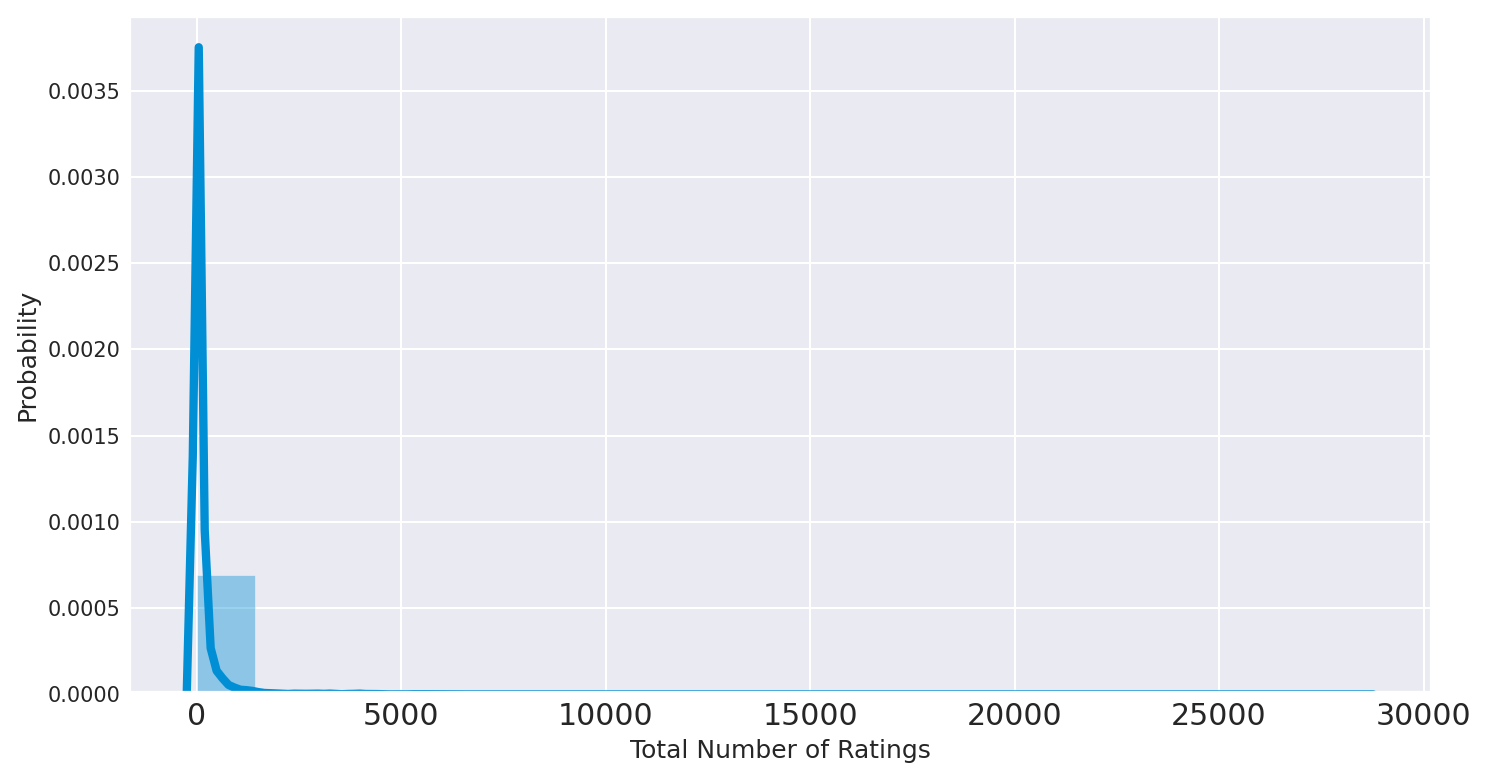

In [15]:
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

We can see that - 
* It is a highly peaked curve.

## Highly Rated Items

In [16]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
item_id,,
8565,5.0,5
9174,5.0,7
5889,5.0,8
5890,5.0,6
194,5.0,5
7114,5.0,7
4625,5.0,7
8256,5.0,5
4639,5.0,5


In [17]:
print('Total no of items that were rated 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of individual users that gave rating of 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) & (df_n_ratings['total ratings'] == 1)]))

Total no of items that were rated 5.0 :  198 

Total no of individual users that gave rating of 5.0 :  5


198 items got the perfect rating of 5.0 but there are only 5 unique users who have given the rating of 5.0

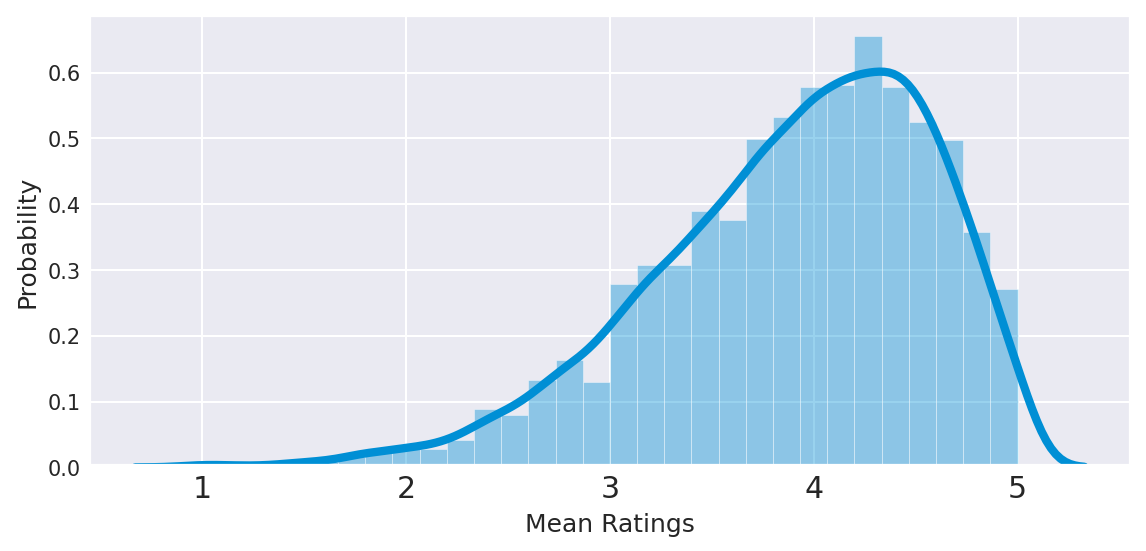

In [18]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

## Mean Ratings vs Total Number of Ratings

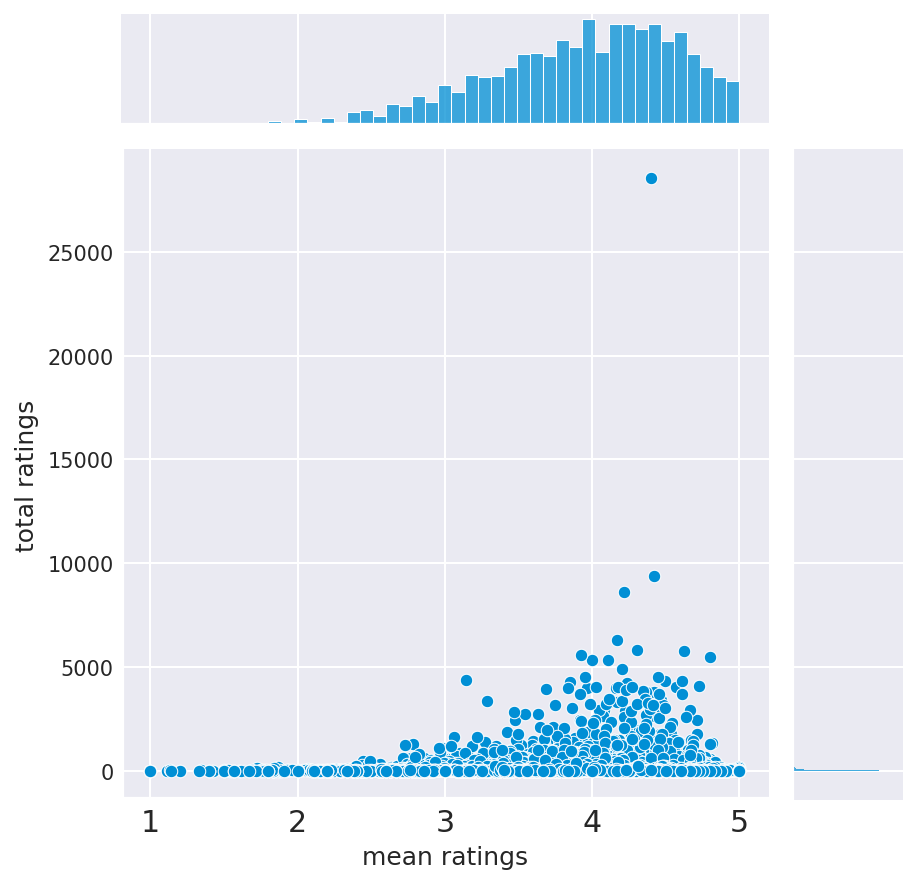

In [19]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

* Here, every Data Point represents a distinct Item, with y-coordinate representing the total no of users which has rated that item and x-coordinate representing the mean of all the ratings of the corresponding users.
* Also there is a huge Density in the region corresponding between mean rating 3-5 .

In [20]:
m['timestamp'] = pd.to_datetime(m['timestamp'])
m['Day'] = m['timestamp'].dt.day
m['Weekday'] = m['timestamp'].dt.weekday
m['Month'] = m['timestamp'].dt.month
m['Year'] = m['timestamp'].dt.year

m.drop('year', axis=1, inplace=True)

In [21]:
m.sort_values(by='timestamp', inplace=True)
m.head()

,item_id,user_id,rating,timestamp,model_attr,category,brand,user_attr,split,Day,Weekday,Month,Year
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,NaN,0,13,6,6,1999
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,NaN,0,14,0,6,1999
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,NaN,0,17,3,6,1999
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,NaN,0,1,3,7,1999
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,NaN,0,6,1,7,1999


In [22]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292954 entries, 0 to 1292953
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   item_id     1292954 non-null  int64         
 1   user_id     1292954 non-null  int64         
 2   rating      1292954 non-null  float64       
 3   timestamp   1292954 non-null  datetime64[ns]
 4   model_attr  1292954 non-null  object        
 5   category    1292954 non-null  object        
 6   brand       331120 non-null   object        
 7   user_attr   174124 non-null   object        
 8   split       1292954 non-null  int64         
 9   Day         1292954 non-null  int64         
 10  Weekday     1292954 non-null  int64         
 11  Month       1292954 non-null  int64         
 12  Year        1292954 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(4)
memory usage: 138.1+ MB


## Check Duplicate Rows if any

In [23]:
duplicate = m[m.duplicated()]
duplicate

,item_id,user_id,rating,timestamp,model_attr,category,brand,user_attr,split,Day,Weekday,Month,Year


There are no duplicate rows!

## Checking Null values

In [24]:
m.isna().sum()

item_id             0
user_id             0
rating              0
timestamp           0
model_attr          0
category            0
brand          961834
user_attr     1118830
split               0
Day                 0
Weekday             0
Month               0
Year                0
dtype: int64

In [25]:
# Dropping all null values & saving it in a new variable
m2 = m.dropna()
m2.isna().sum()

item_id       0
user_id       0
rating        0
timestamp     0
model_attr    0
category      0
brand         0
user_attr     0
split         0
Day           0
Weekday       0
Month         0
Year          0
dtype: int64

In [26]:
m2.shape

(45166, 13)

## Find unique values of each column

In [27]:
m2.nunique()

item_id        1892
user_id       40401
rating            5
timestamp      4179
model_attr        3
category         10
brand            50
user_attr         2
split             3
Day              31
Weekday           7
Month            12
Year             19
dtype: int64

There are 1892 different items,
40401 different users

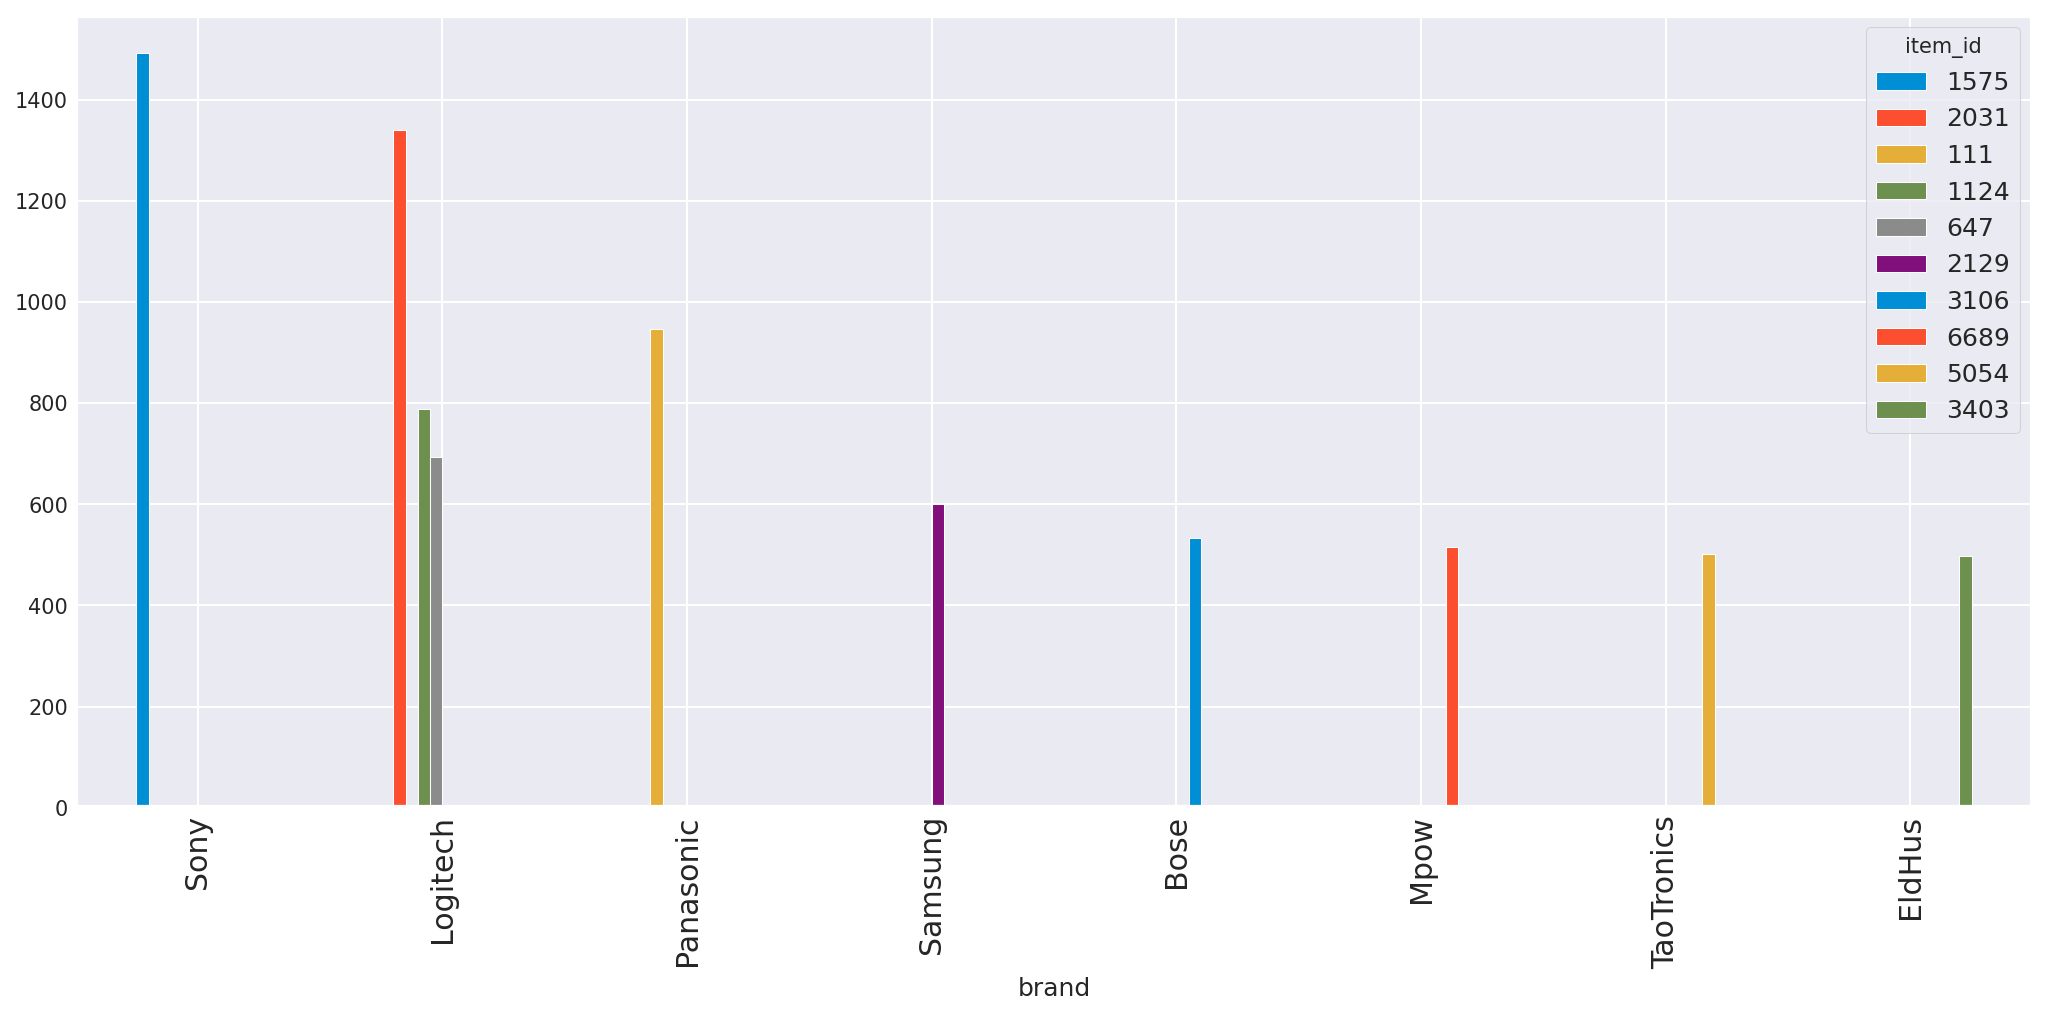

In [28]:
brand_grp = m2.groupby('brand')

brand_grp['item_id'].value_counts().nlargest(10).unstack().plot(kind='bar', figsize=(15, 7));

Sony's item_id 1575 is the most selling followed by Logitech, Samsung and Bose's items

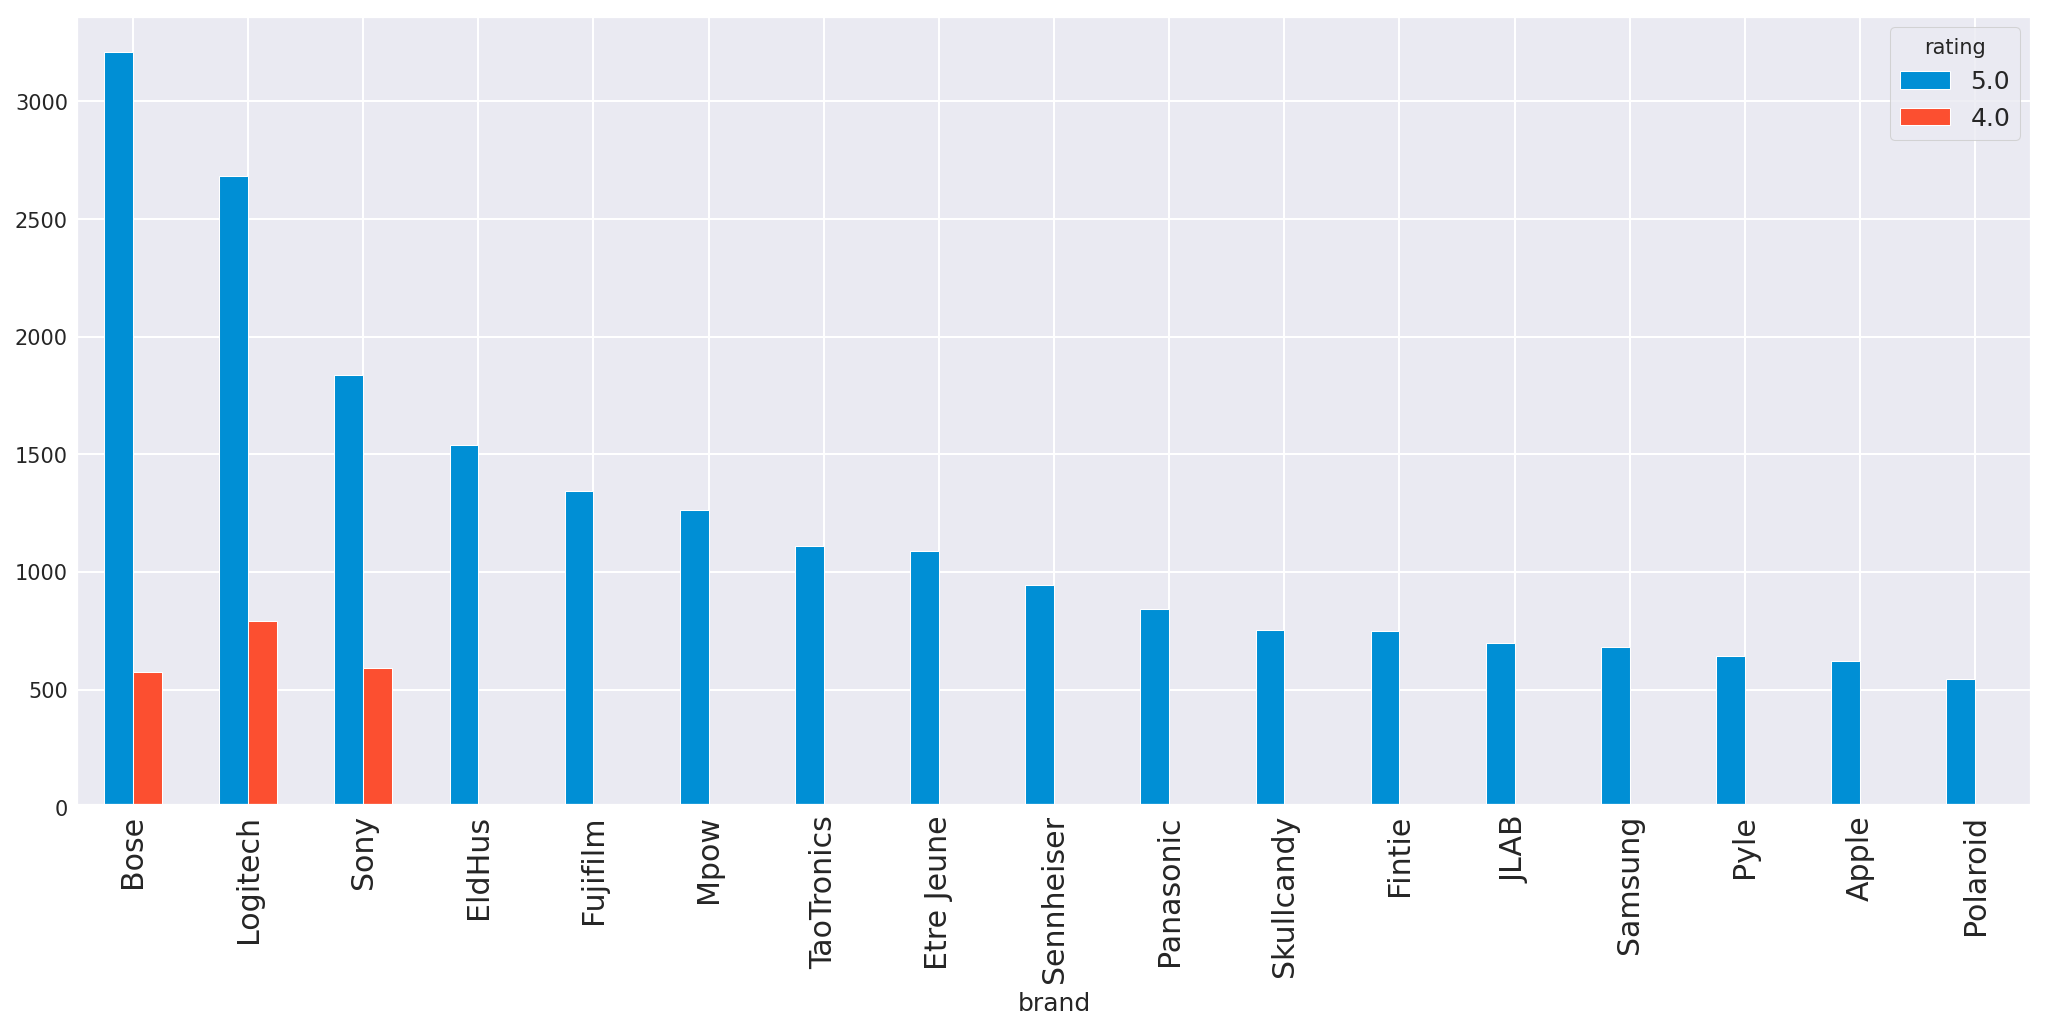

In [29]:
brand_grp['rating'].value_counts().nlargest(20).unstack().plot(kind='bar', figsize=(15, 7));

Bose items have got the maximum number of 5.0 rating.

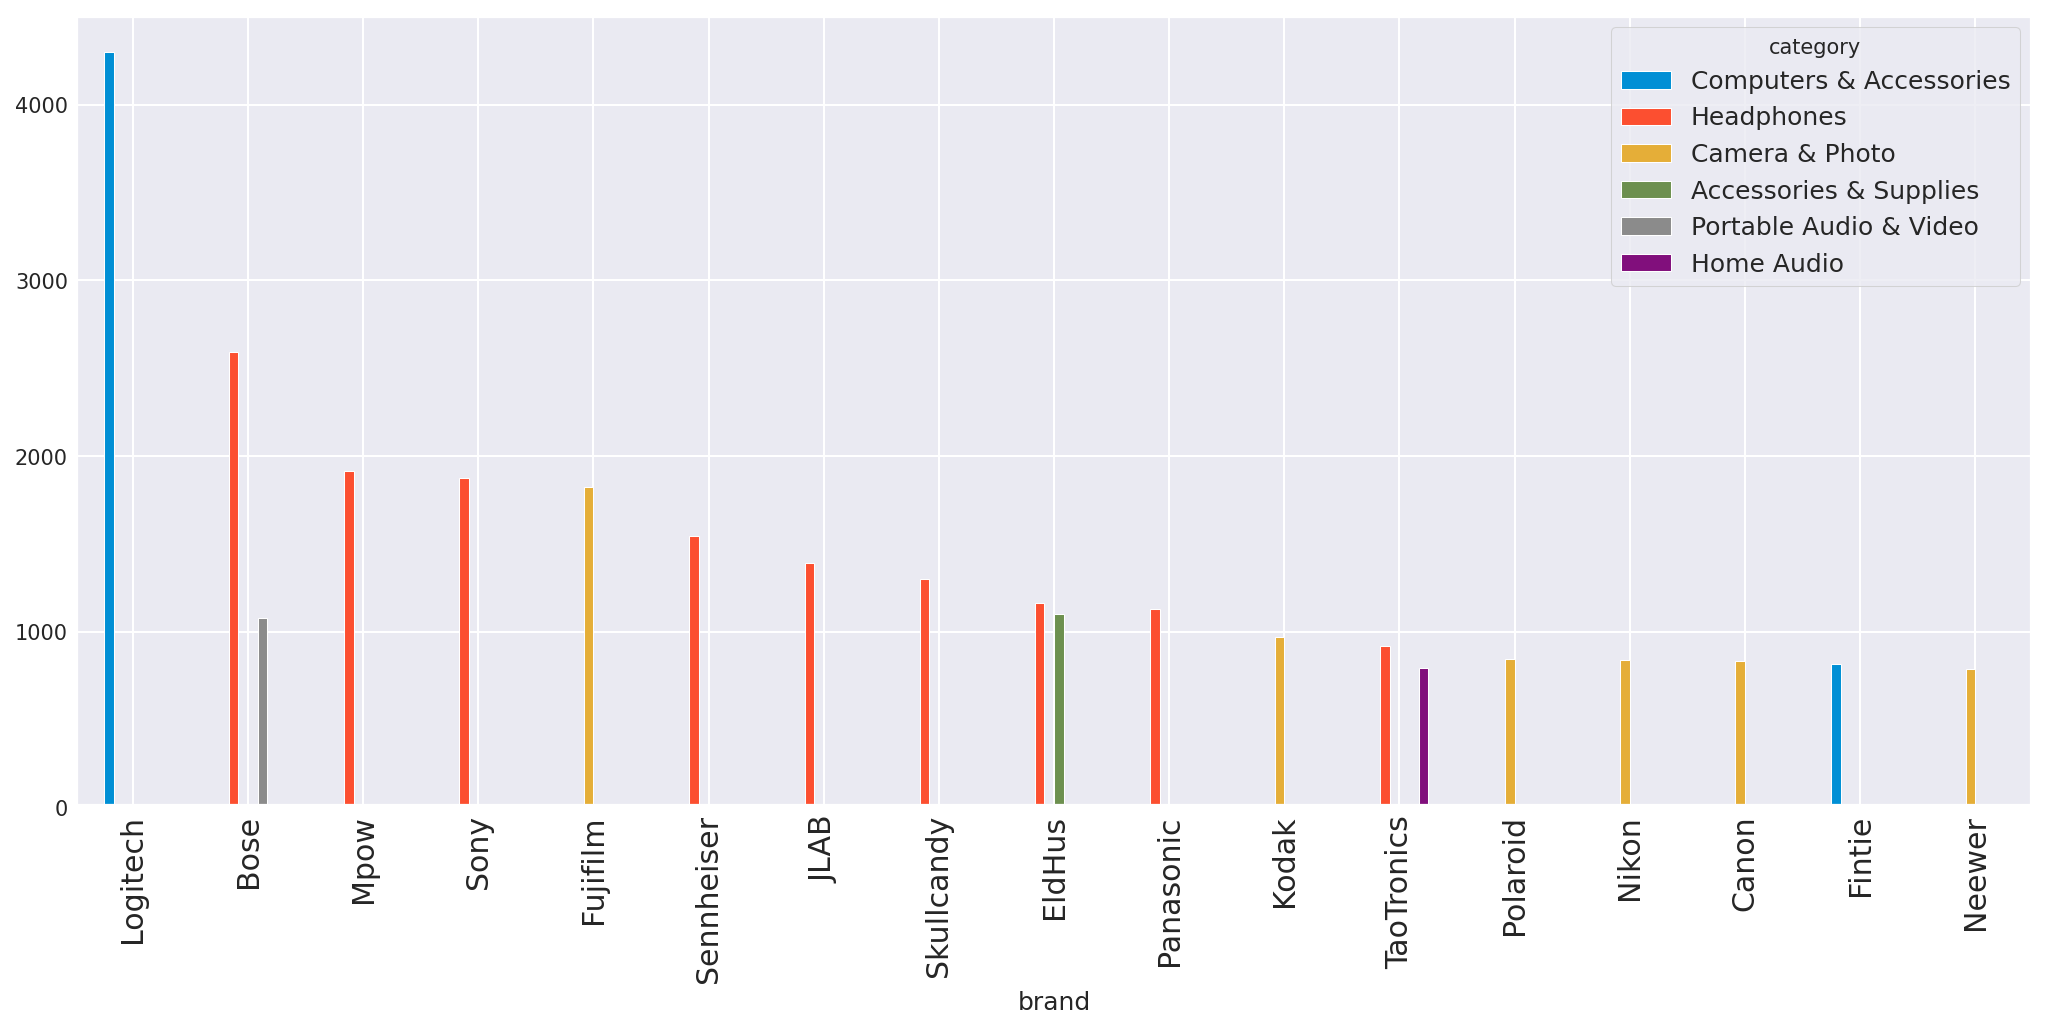

In [30]:
brand_grp['category'].value_counts().nlargest(20).unstack().plot(kind='bar', figsize=(15, 7));

In the category 'Computers & Accessories' Logitech is leading in terms of highest selling items.

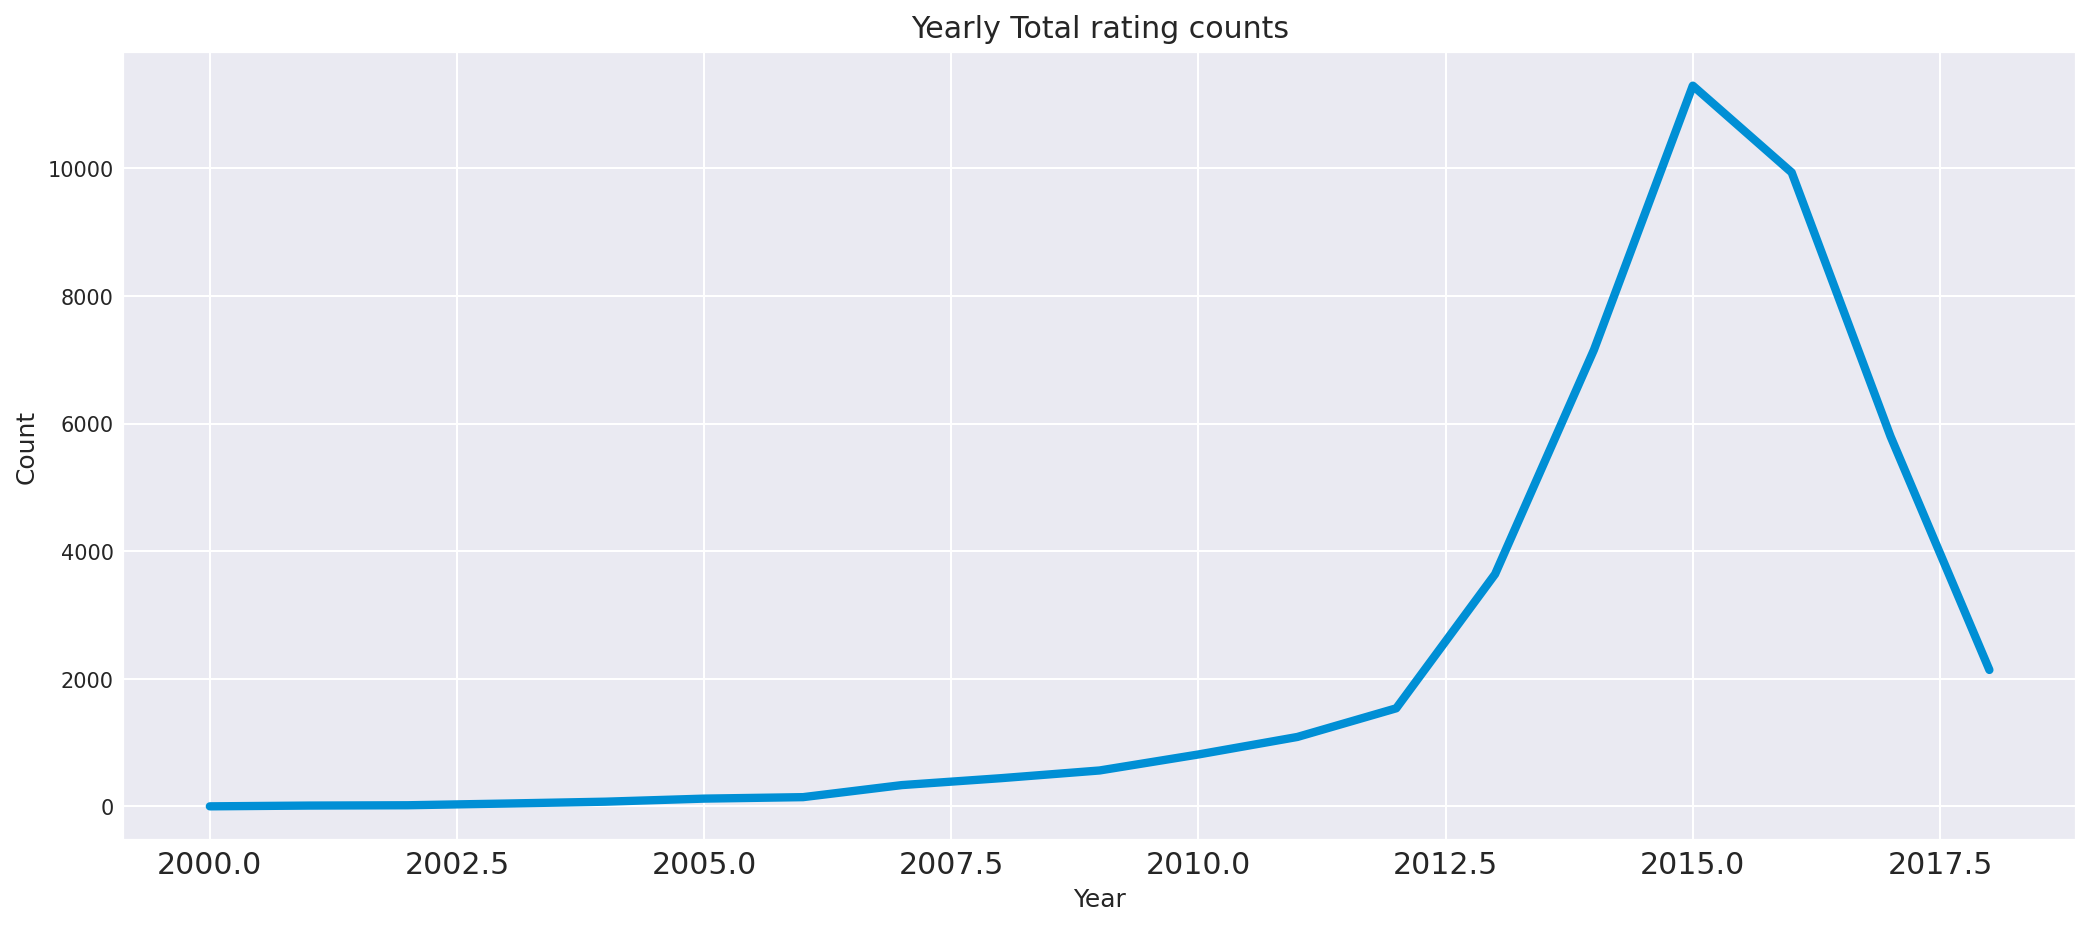

In [31]:
plt.figure(figsize=(15,7))
m2.groupby('Year')['rating'].count().plot(kind='line');
plt.title('Yearly Total rating counts')
plt.ylabel('Count')
plt.show()

Highest number of ratings was given in the year 2015

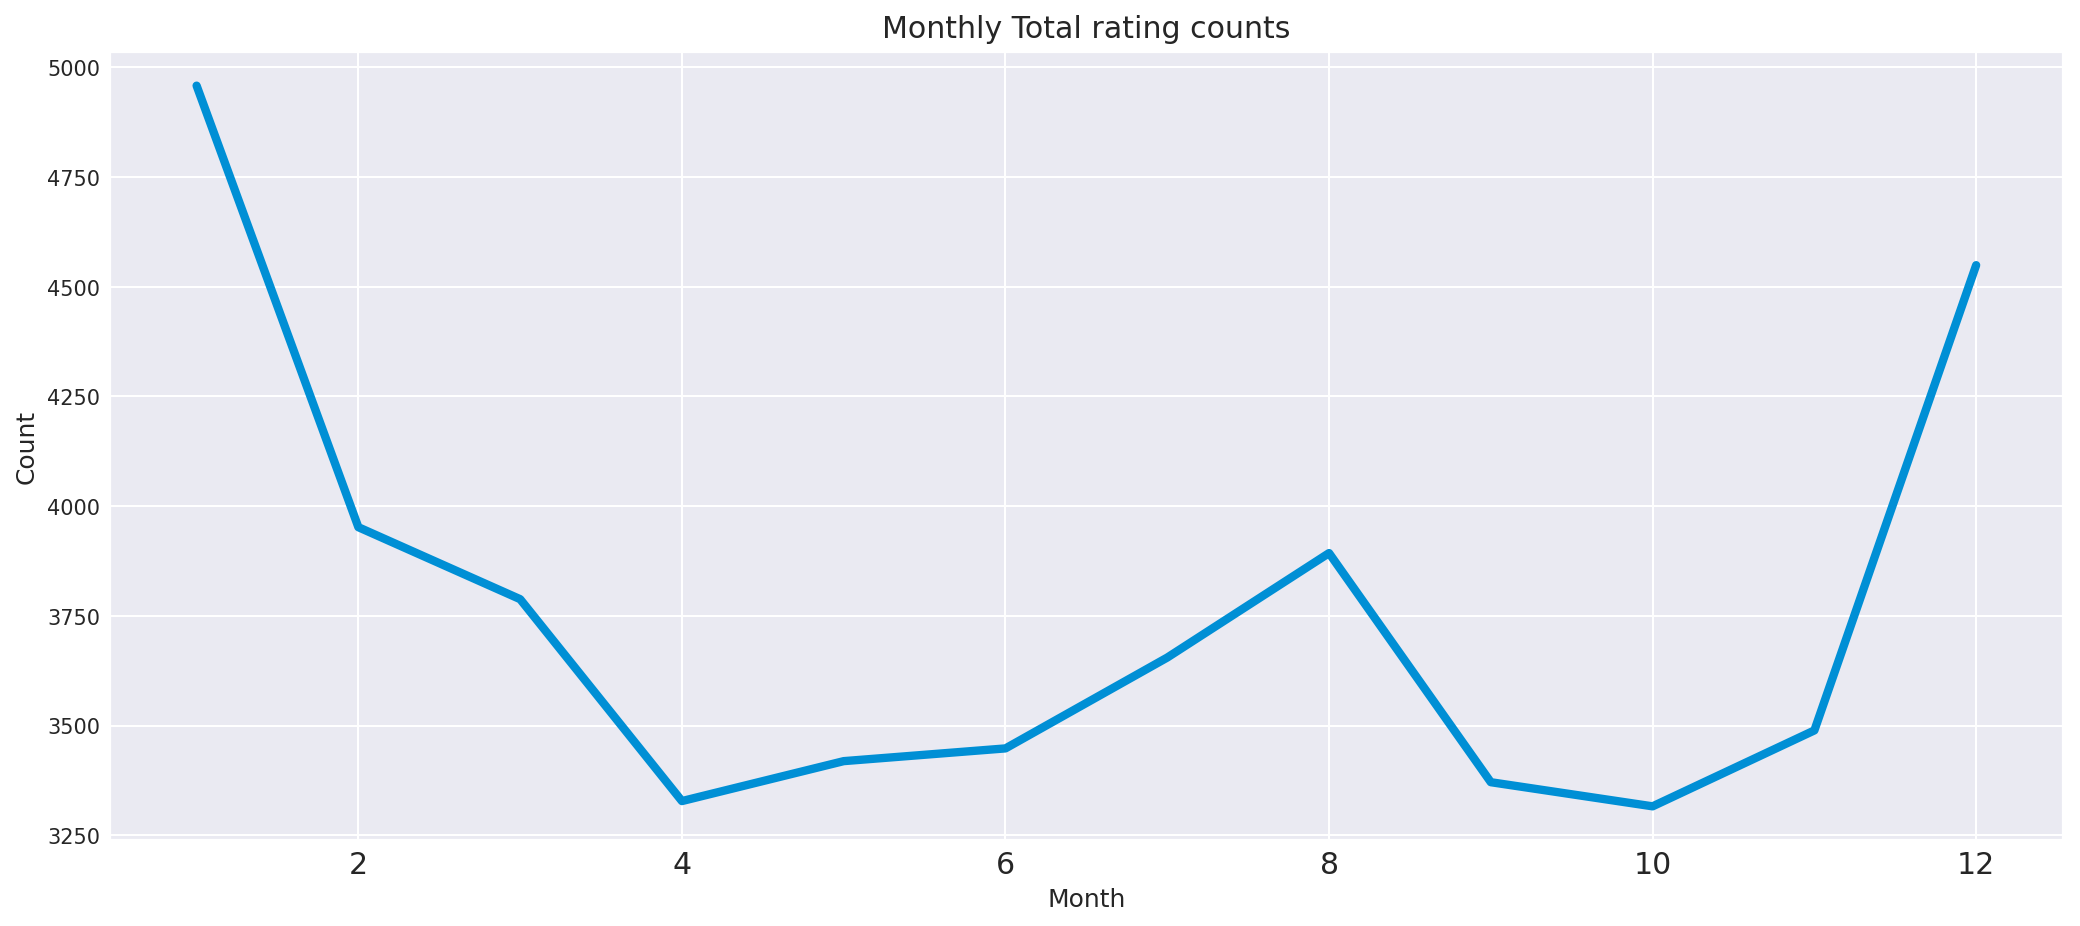

In [32]:
plt.figure(figsize=(15,7))
m2.groupby('Month')['rating'].count().plot(kind='line');
plt.title('Monthly Total rating counts')
plt.ylabel('Count')
plt.show()

During January and December there is a drastic decrease in the number of ratings given by the users.

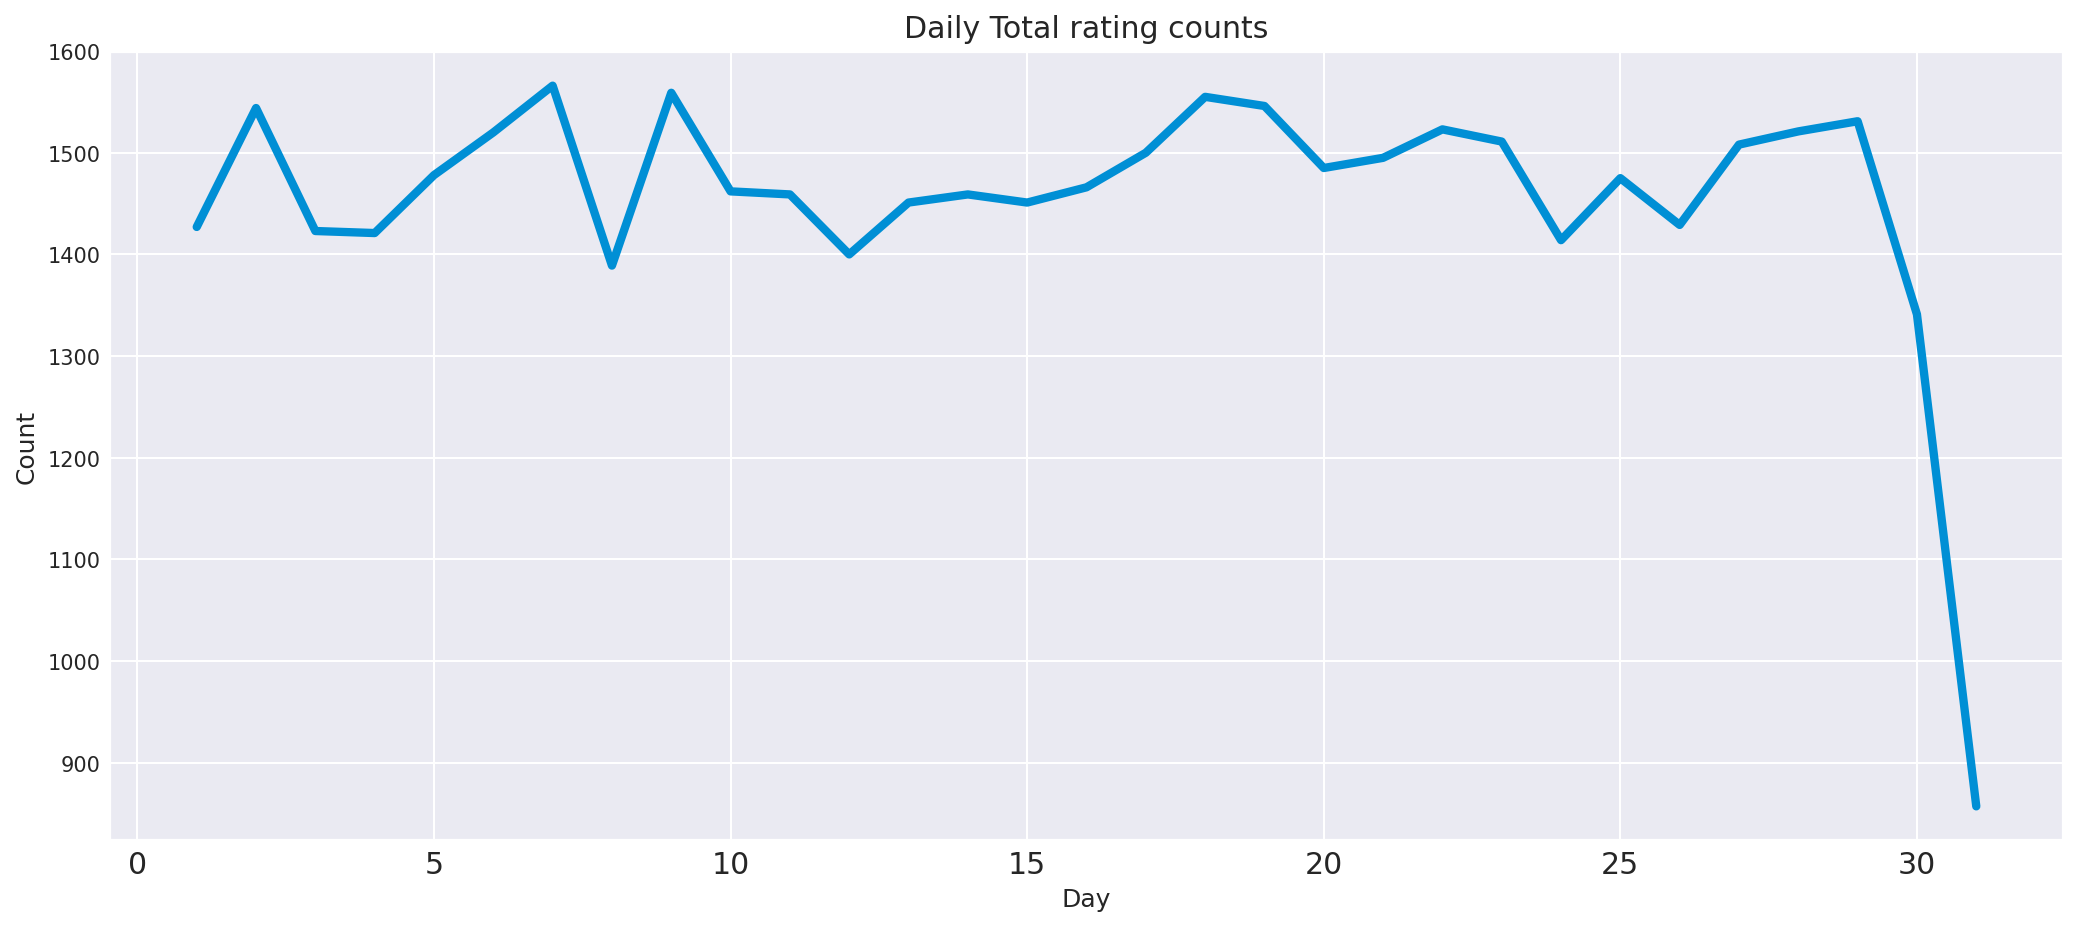

In [33]:
plt.figure(figsize=(15,7))
m2.groupby('Day')['rating'].count().plot(kind='line');
plt.title('Daily Total rating counts')
plt.ylabel('Count')
plt.show()

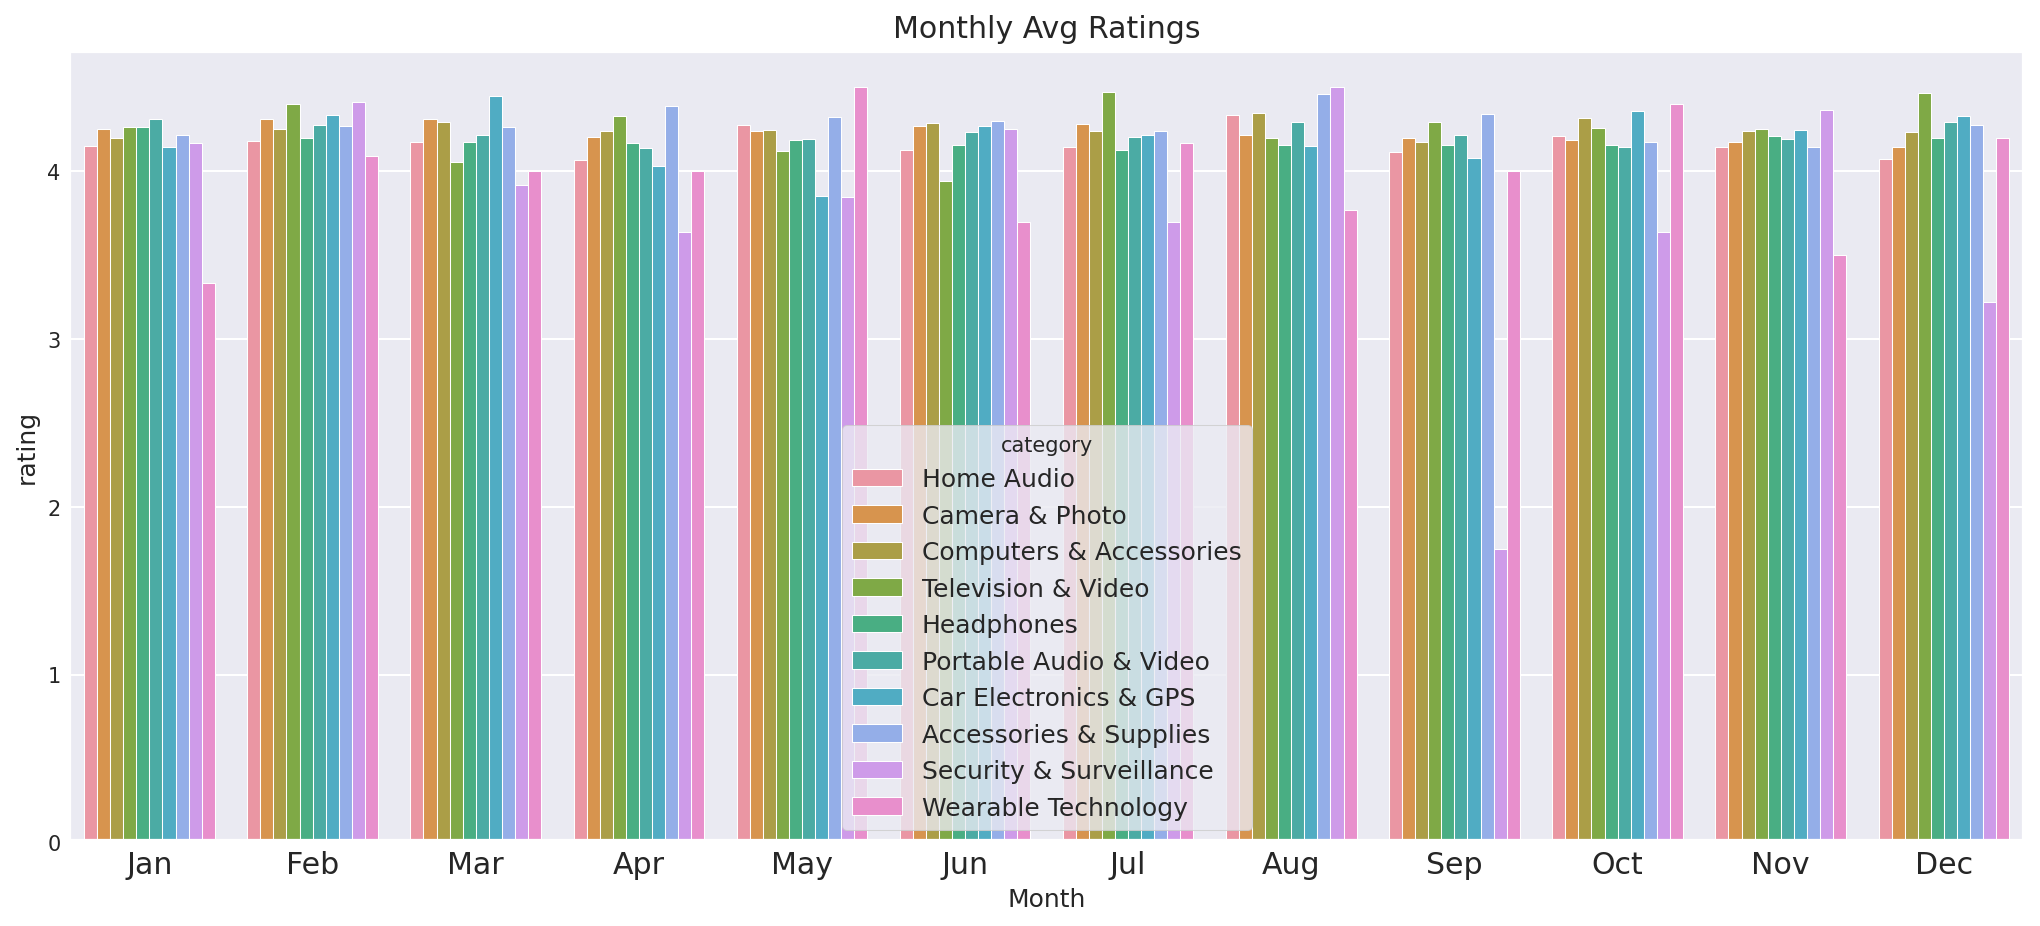

In [34]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(15,7))
g = sns.barplot('Month', 'rating', data=m2, hue='category', ci=None);
g.set_xticklabels(labels=month, rotation=0)
g.set_title('Monthly Avg Ratings')
plt.show()

Avg rating of 'Security & Surveillance' in the month of September has a drastic decrease.

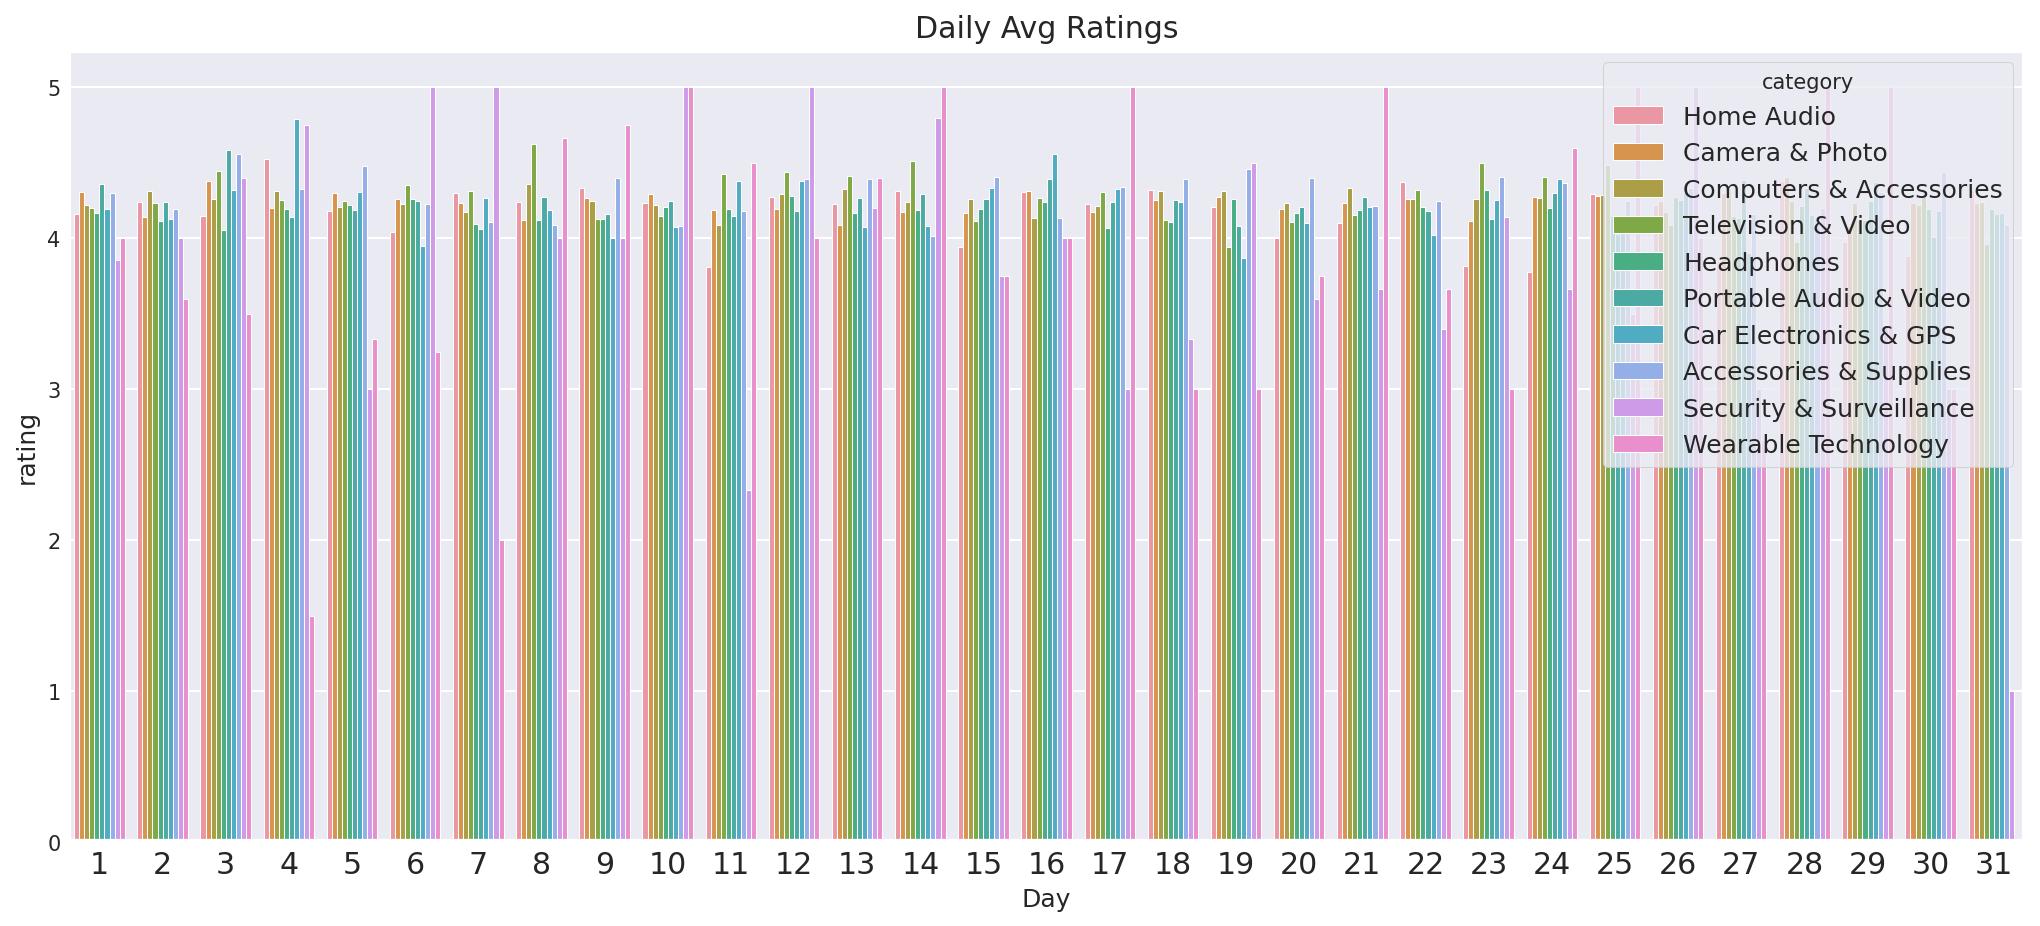

In [35]:
plt.figure(figsize=(15,7))
g = sns.barplot('Day', 'rating', data=m2, hue='category', ci=None);
g.set_title('Daily Avg Ratings')
plt.show()

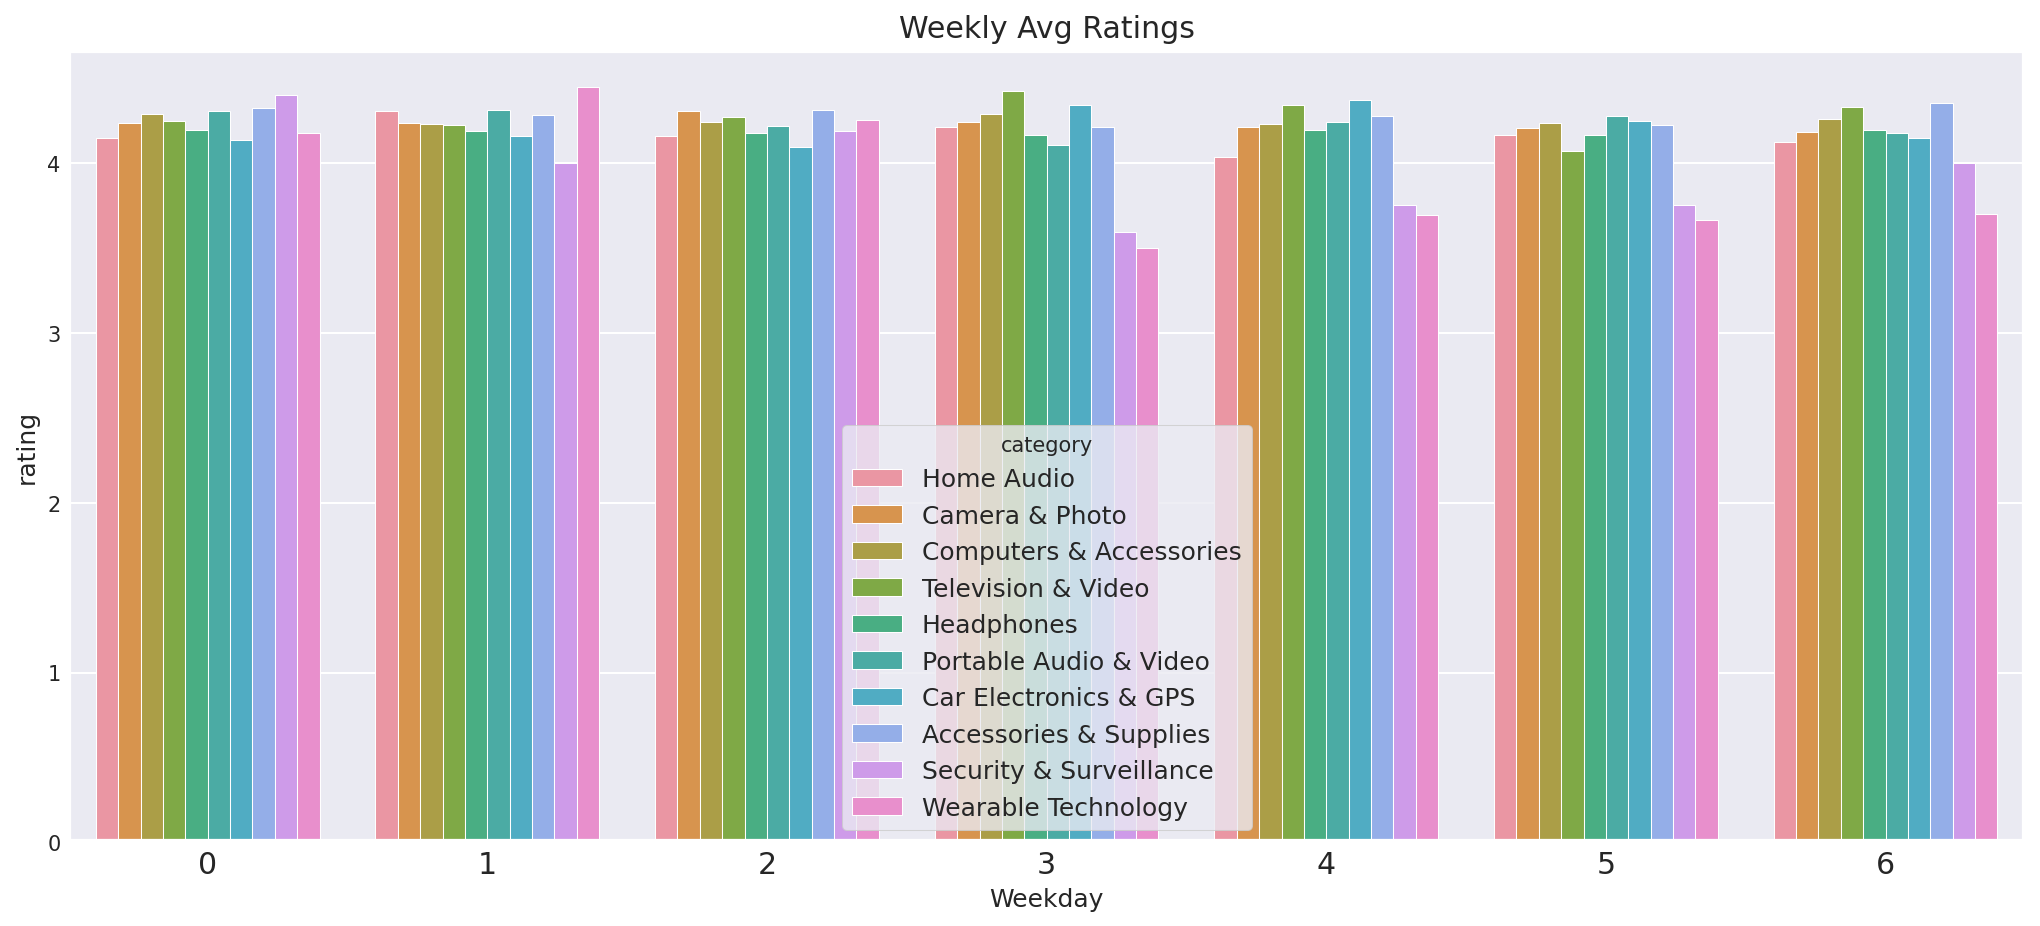

In [36]:
plt.figure(figsize=(15,7))
g = sns.barplot('Weekday', 'rating', data=m2, hue='category', ci=None);
g.set_title('Weekly Avg Ratings')
plt.show()

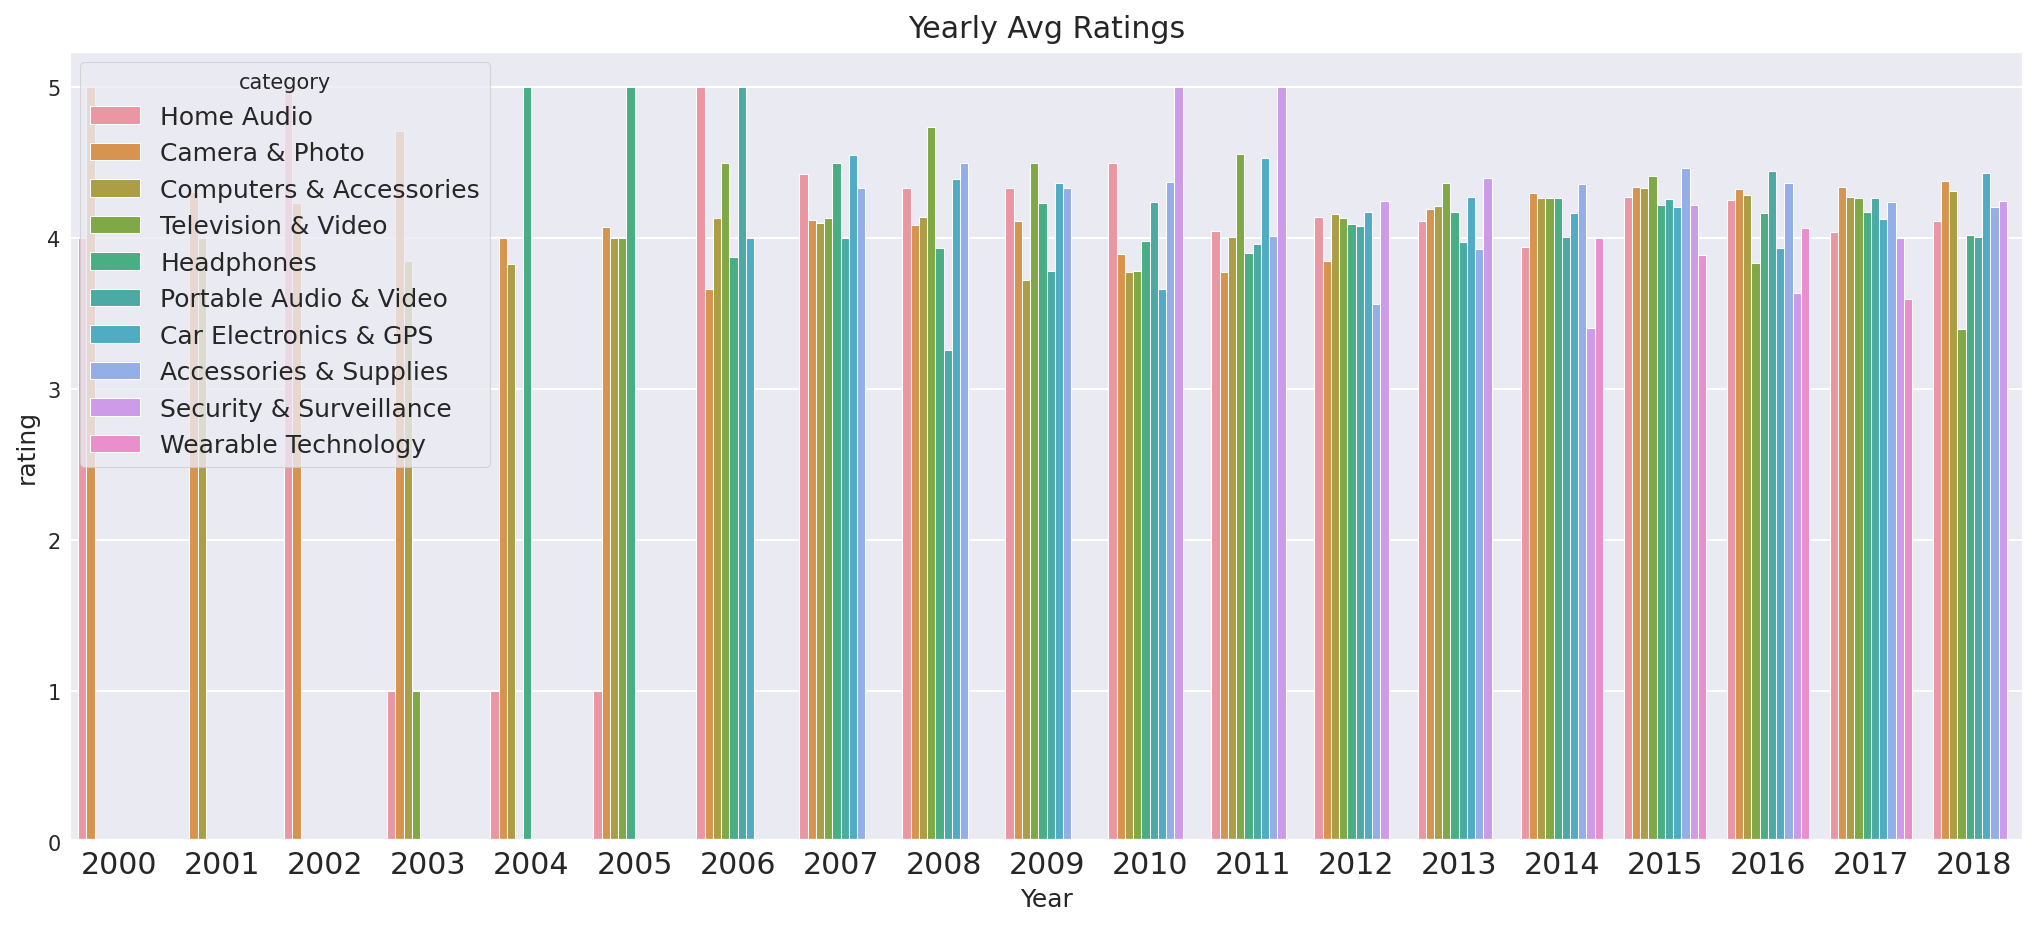

In [37]:
plt.figure(figsize=(15,7))
g = sns.barplot('Year', 'rating', data=m2, hue='category', ci=None);
g.set_title('Yearly Avg Ratings')
plt.show()

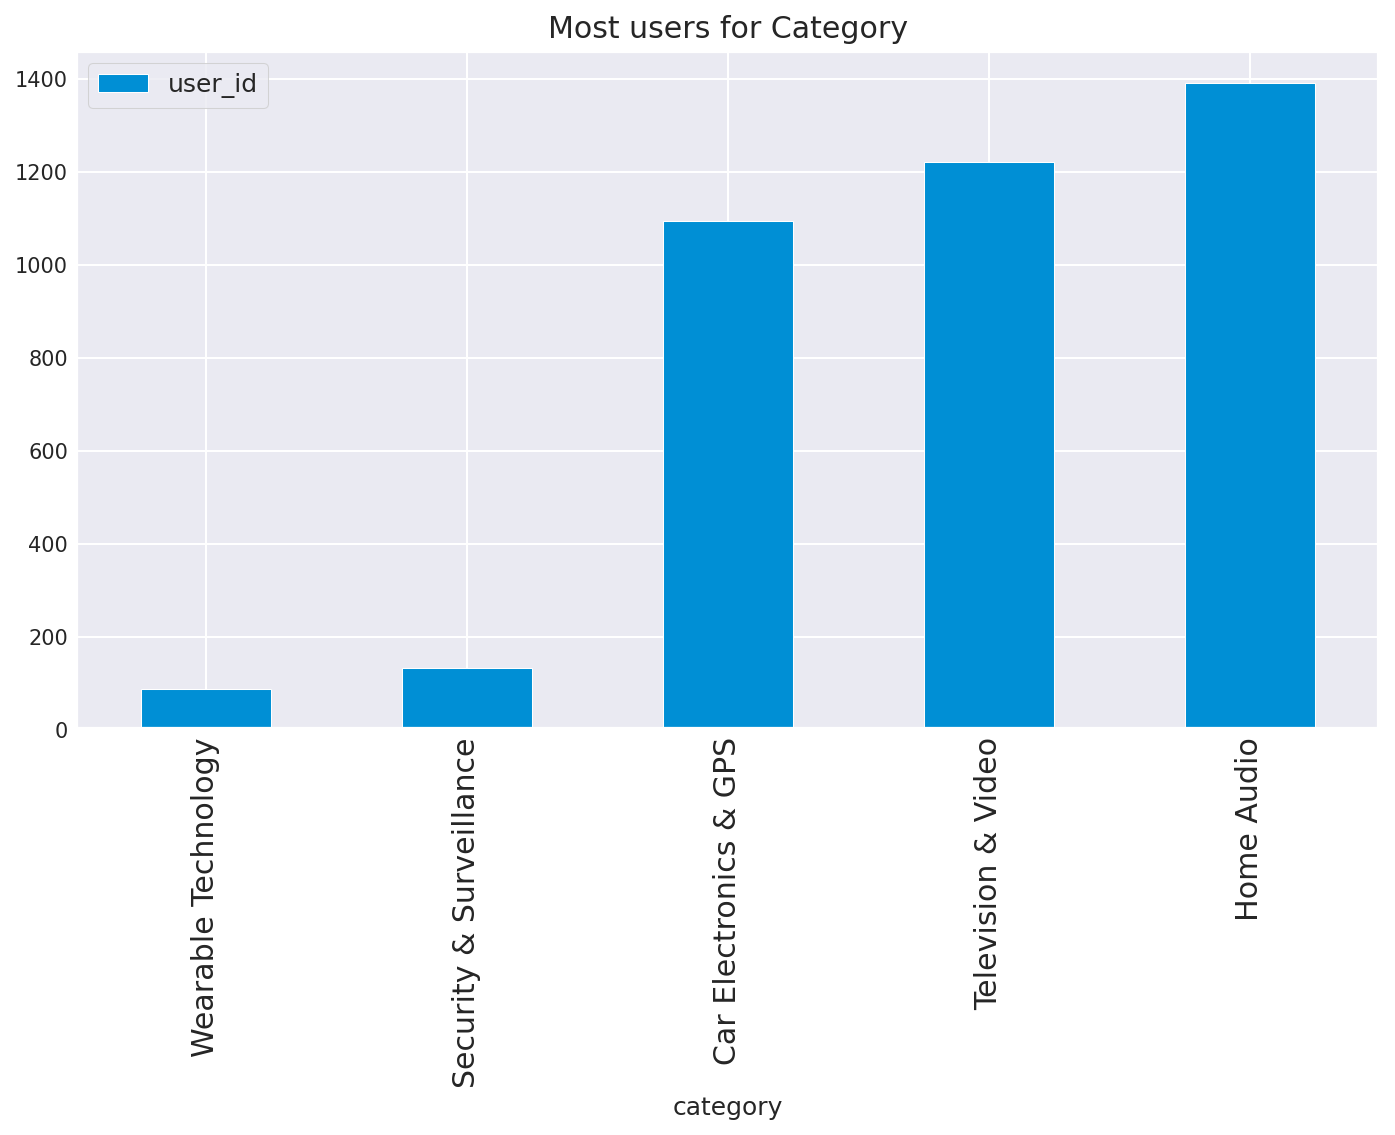

In [38]:
cat = pd.DataFrame(m2.groupby('category')['user_id'].count().sort_values(ascending=True))
cat[:5].plot(kind='bar', title='Most users for Category')

Most preferred category is 'Home Audio' whereas least prefered is 'Wearable Technology'.

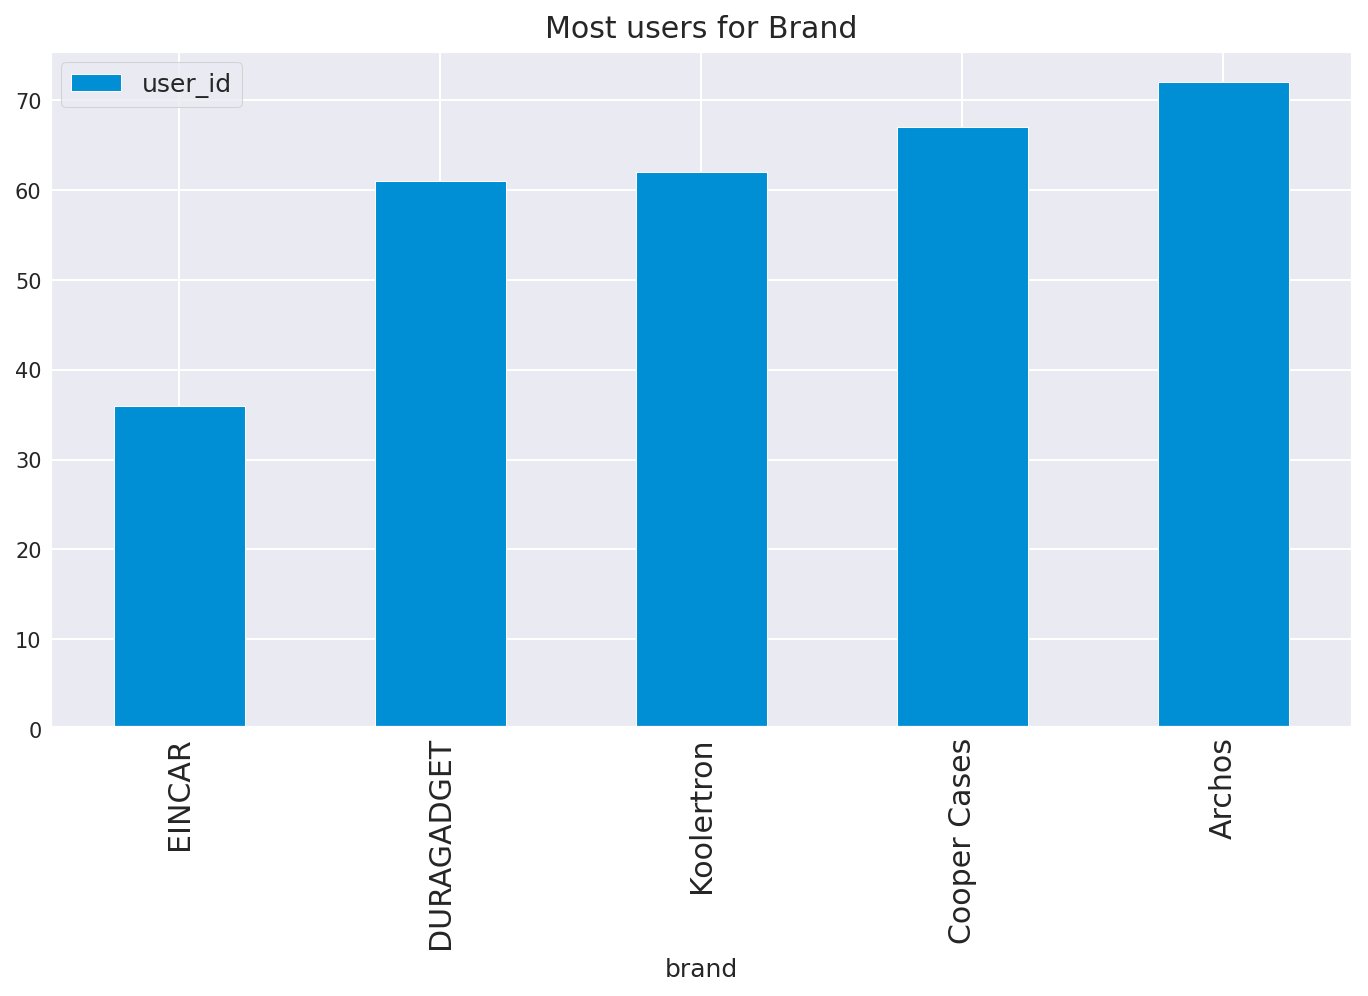

In [39]:
br = pd.DataFrame(m2.groupby('brand')['user_id'].count().sort_values(ascending=True))
br[:5].plot(kind='bar', title='Most users for Brand')

Most preferred brand is 'Archors'.

# Data Cleaning before building Recommendation System

In [40]:
m.isna().sum()

item_id             0
user_id             0
rating              0
timestamp           0
model_attr          0
category            0
brand          961834
user_attr     1118830
split               0
Day                 0
Weekday             0
Month               0
Year                0
dtype: int64

In [41]:
m.drop(['timestamp', 'model_attr', 'category', 'brand', 'model_attr', 'user_attr', 'split', 'Day', 'Weekday', 'Month', 'Year'], axis=1, inplace=True)
m.head()

,item_id,user_id,rating
0,0,0,5.0
1,0,1,5.0
2,0,2,3.0
3,0,3,1.0
4,0,4,2.0


In [42]:
m.shape

(1292954, 3)

### Removing all users who have rated < 5 items.

In [43]:
m = m.groupby('user_id').filter(lambda x: len(x) >= 5)
m.shape

(15594, 3)

## Model-based collaborative filtering system
Utility Matrix based on products sold and user reviews

Utility Matrix : An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [44]:
ratings_utility_matrix = m.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
ratings_utility_matrix.head()

item_id,0,2,3,10,14,15,16,17,21,24,33,39,40,43,46,56,62,63,64,73,74,75,77,79,80,81,83,86,87,88,89,91,92,93,94,95,96,97,98,99,...,9283,9288,9297,9299,9301,9304,9305,9308,9311,9315,9320,9322,9327,9341,9345,9361,9363,9380,9383,9392,9406,9407,9421,9429,9443,9446,9452,9467,9468,9484,9490,9503,9504,9505,9509,9510,9516,9519,9525,9537
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158,0,0,2,0,4,0,3,0,0,5,0,0,4,0,3,0,0,5,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269,0,0,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,0,0,0,0,0,0,0,0,0,0,0,0,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
ratings_utility_matrix.shape

(2375, 3693)

In [46]:
X = ratings_utility_matrix.T
X.head()

user_id,28,158,269,372,789,822,959,1007,1073,1107,1156,1170,1188,1277,1312,1323,1329,1366,1393,1489,1499,1544,1670,1688,1732,1745,1792,1852,1858,1946,2061,2080,2111,2207,2262,2293,2344,2381,2418,2620,...,822124,827864,835111,847053,849928,857005,858415,863352,863704,866485,868566,870570,871475,873502,873703,880817,890040,893097,899072,899955,907563,911696,919192,919932,921023,926621,941403,952631,956132,964949,974358,978504,993877,997749,1026892,1029468,1034031,1044355,1103510,1119770
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
X.shape

(3693, 2375)

In [48]:
!pip install surprise

     |████████████████████████████████| 11.8MB 250kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617654 sha256=abc224084f0a11965d3a30f9df899d3ddeed71e9fa7fa69f6bc52ffe292dd568
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [49]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from collections import defaultdict

In [50]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data1 = Dataset.load_from_df(m, reader)
data1

In [51]:
#Splitting the dataset
trainset, testset = train_test_split(data1, test_size=0.2, random_state=123)

In [52]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0), (375, 5.0), (979, 5.0), (999, 5.0), (1474, 5.0)],
             1: [(1, 5.0),
              (431, 4.0),
              (1384, 5.0),
              (725, 4.0),
              (1599, 5.0),
              (1163, 5.0),
              (444, 4.0),
              (445, 5.0),
              (1848, 5.0),
              (1558, 3.0),
              (2342, 5.0),
              (1243, 3.0),
              (1598, 3.0),
              (2243, 5.0)],
             2: [(2, 5.0),
              (1039, 5.0),
              (2039, 4.0),
              (1983, 4.0),
              (1050, 5.0),
              (2161, 5.0)],
             3: [(3, 4.0),
              (781, 1.0),
              (1228, 4.0),
              (1260, 5.0),
              (757, 5.0),
              (312, 4.0),
              (1655, 5.0),
              (1657, 4.0),
              (2035, 5.0),
              (1116, 5.0),
              (2131, 5.0),
              (977, 5.0),
              (1801, 5.0),
              (1297,

**Collaborative filtering** is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources.Basically, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users. 

There are 2 approaches to CF -->

1) **Memory-Based CF** - It is an approach which finds similarity between users or between items to recommend similar items. Examples include Neighbourhood-based CF and Item-based/User-based top-N recommendations.

2) **Model-Based CF** - In this approach we use different data mining, machine learning algorithms to predict users' rating of unrated items.  Examples include Singular Value Decomposition (SVD) , Principal Component Analysis (PCA) etc.

In [53]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=30, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [54]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [55]:
test_pred

[Prediction(uid=3660, iid=211150, r_ui=3.0, est=4.0, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6652, iid=132511, r_ui=4.0, est=4.4, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=2126, iid=172800, r_ui=5.0, est=3.7142857142857144, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=3653, iid=173142, r_ui=4.0, est=2.75, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=4277, iid=201059, r_ui=4.0, est=4.3478260869565215, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=468, iid=93904, r_ui=5.0, est=3.6666666666666665, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=1861, iid=704271, r_ui=5.0, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=972, iid=11939, r_ui=4.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=4528, iid=233365, r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=8367, iid=

In [56]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [57]:
top_n = get_top_n(test_pred, n=5)
top_n

defaultdict(list,
            {3660: [(268634, 4.333333333333333), (211150, 4.0), (251624, 4.0)],
             6652: [(132511, 4.4),
              (468210, 4.0),
              (113918, 2.6666666666666665)],
             2126: [(154462, 5),
              (85958, 4.009090909090909),
              (172800, 3.7142857142857144)],
             3653: [(173142, 2.75)],
             4277: [(208002, 4.9411764705882355),
              (4934, 4.479319223409632),
              (201059, 4.3478260869565215)],
             468: [(332804, 5),
              (521147, 5),
              (467554, 5),
              (85709, 5),
              (36843, 5)],
             1861: [(135636, 4.666666666666667),
              (16485, 4.666666666666667),
              (704271, 4.5),
              (87425, 4.25),
              (142085, 3.8333333333333335)],
             972: [(11939, 5)],
             4528: [(233365, 5)],
             8367: [(346874, 5), (201059, 4.5978260869565215)],
             5884: [(533228, 5),
    

In [58]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

3660 [268634, 211150, 251624]
6652 [132511, 468210, 113918]
2126 [154462, 85958, 172800]
3653 [173142]
4277 [208002, 4934, 201059]
468 [332804, 521147, 467554, 85709, 36843]
1861 [135636, 16485, 704271, 87425, 142085]
972 [11939]
4528 [233365]
8367 [346874, 201059]
5884 [533228, 497427, 167054, 579231, 919932]
1752 [67934]
7780 [326452, 384487, 14391, 435984, 371221]
1539 [35600, 64472, 64708]
1919 [20275, 2418]
1128 [276382]
5178 [352550, 822124, 919932, 79600, 5400]
4730 [60395, 34524]
162 [111381, 642784, 593548]
1607 [4934, 63547, 33099]
234 [1277]
4420 [213349, 237388, 103065, 115960, 280770]
1097 [3054, 1007]
1455 [172868, 7605]
3878 [31996, 610271, 348972]
4086 [242139]
1169 [651850, 340173, 172800]
871 [16528]
1758 [4022]
7827 [119376, 58601, 105860, 470430]
1683 [74798]
1496 [420071, 85568, 55114, 256872, 94270]
8221 [289274, 33381]
6072 [367842, 37749, 179602]
94 [1792]
4576 [84956, 277870, 50755, 295149]
6642 [356547]
2016 [378854, 8193, 156041, 343933, 83409]
43 [213134, 24

## Evaluate the above model

In [59]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1127


1.112720677846717

In [60]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

In [61]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(m, reader)
data

In [62]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1365  1.1403  1.1217  1.1441  1.1681  1.1421  0.0151  
Fit time          0.51    0.43    0.40    0.41    0.46    0.44    0.04    
Test time         0.06    0.07    0.06    0.06    0.06    0.06    0.00    


{'fit_time': (0.5130138397216797,
  0.42650365829467773,
  0.3989529609680176,
  0.41149115562438965,
  0.4580657482147217),
 'test_rmse': array([1.13646587, 1.14031964, 1.12166849, 1.14405487, 1.1681401 ]),
 'test_time': (0.06274795532226562,
  0.06611800193786621,
  0.05772852897644043,
  0.05777597427368164,
  0.05942058563232422)}

### Tuning KNN using GridSearchCV

In [63]:
n_neighbours = [10, 15, 20, 25, 30, 35, 40]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### Singular Value Decomposition (SVD)

In [64]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0326  1.0429  1.0464  1.0104  1.0443  1.0353  0.0133  
Fit time          0.85    0.85    0.85    0.86    0.85    0.85    0.00    
Test time         0.06    0.03    0.03    0.03    0.03    0.04    0.01    


{'fit_time': (0.8504915237426758,
  0.8483867645263672,
  0.8512718677520752,
  0.8561580181121826,
  0.8505260944366455),
 'test_rmse': array([1.03261831, 1.04289988, 1.04642734, 1.0104038 , 1.04434189]),
 'test_time': (0.06458234786987305,
  0.03181576728820801,
  0.029162168502807617,
  0.02783823013305664,
  0.030733585357666016)}

**Fine Tuning SVD using GridSearchCV**

[View the parameters](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

In [65]:
param_grid = {'n_factors' : [50, 100], 'lr_all' : [0.5, 0.005], 'reg_all' : [0.06, 0.02]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 1.0304566502278834
Best Parameters : {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02}
###############


### Non-Negative Matrix Factorization (NMF)

In [66]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2726  1.2406  1.2496  1.2676  1.2501  1.2561  0.0120  
Fit time          1.32    1.24    1.35    1.27    1.30    1.29    0.04    
Test time         0.03    0.02    0.03    0.02    0.03    0.03    0.00    


{'fit_time': (1.3240103721618652,
  1.2371551990509033,
  1.3475003242492676,
  1.2697670459747314,
  1.296480655670166),
 'test_rmse': array([1.2725847 , 1.24056492, 1.24961486, 1.26764576, 1.25006201]),
 'test_time': (0.032204389572143555,
  0.0247342586517334,
  0.025223493576049805,
  0.02298426628112793,
  0.028769493103027344)}

In [68]:
param_grid = {'n_factors' : [50, 100]}

gs = GridSearchCV(algo_class=NMF, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 1.1648760172349772
Best Parameters : {'n_factors': 50}
###############
